In [1]:
import torch
from datasets.data_loaders import get_data, get_data_loaders
import sys 
sys.path.append('r/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm')
from flax import nnx
import jax.numpy as jnp
import jax.random as jr
import jax
from flax import nnx
import matplotlib.pyplot as plt # creating visualizations
import optax
from inference import OtherMAF
import orbax.checkpoint as ocp

In [2]:
# path = ocp.test_utils.erase_and_create_empty('/tmp/my-checkpoints/')
# checkpointer = ocp.StandardCheckpointer()

# _, state = nnx.split(model)
# # nnx.display(state)
# checkpointer = ocp.StandardCheckpointer()
# checkpointer.save(path/ 'state', state)

# # Restore the checkpoint back to its `nnx.State` structure - need an abstract reference.
# abstract_model = nnx.eval_shape(lambda: OtherMAF(din, nmades, dhidden, nhidden, rngs=nnx.Rngs(1), use_reverse=reverse))
# graphdef, abstract_state = nnx.split(abstract_model)
# print('The abstract NNX state (all leaves are abstract arrays):')
# nnx.display(abstract_state)

# state_restored = checkpointer.restore(path / 'state', abstract_state)
# jax.tree.map(np.testing.assert_array_equal, state, state_restored)
# print('NNX State restored: ')
# nnx.display(state_restored)

# # The model is now good to use!
# model = nnx.merge(graphdef, state_restored)
# # assert model(x).shape == (3, 4)

In [3]:
@nnx.jit  # automatic state management
def train_step(model, optimizer, data):
  loss_fn = lambda model: model.loss_fn(data)
  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # inplace updates
  return loss

In [4]:
key1, key2 = jr.split(jr.PRNGKey(0))


##### Search-relevant hyperparameters #########
reverse = True

nmades = 5
dhidden = 512
nhidden = 1
num_epochs = 20
minibatch_size = 128
learning_rate = 1 * 1e-4
weight_decay = 1 * 1e-6

#### LOAD DATA 
data = get_data('mnist')
train_loader, val_loader, test_loader  = get_data_loaders(data, minibatch_size)
din = data.n_dims

#### INITIALIZE MODEL AND OPTIMIZER
model = OtherMAF(din, nmades, dhidden, nhidden, nnx.Rngs(0), False, reverse, False, False)
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, weight_decay=weight_decay)) 

#### TRAINING LOOP
train_losses = []
val_losses = []
keys = jr.split(key1, num_epochs)
for i in range(num_epochs):
  key, subkey = jr.split(keys[i])
  model.train()
  train_loss = []
  val_loss = []
  model.train()
  for batch in train_loader:
      batch = jnp.array(batch)
      loss = train_step(model, optimizer, batch)
      train_loss.append(loss)
  model.eval()
  for batch in val_loader:
      batch = jnp.array(batch)
      loss = model.loss_fn(batch)
      val_loss.append(loss)

  train_loss = jnp.mean(jnp.array(train_loss))
  val_loss = jnp.mean(jnp.array(val_loss))
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print(f"Epoch {i}, training loss: {train_loss}, validation loss: {val_loss}")


setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
Epoch 0, training loss: 1612.028564453125, validation loss: 1570.152587890625
setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
Epoch 1, training loss: 1499.2718505859375, validation loss: 1506.4342041015625
setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
Epoch 2, training loss: 1445.5665283203125, validation loss: 1466.1571044921875
setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
setting batch stats for validation
Epoch 3, training loss: 1408.984619140625, validation loss: 14

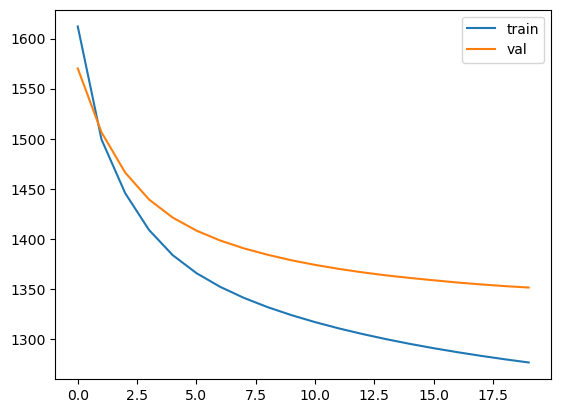

In [5]:
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.legend()
plt.show()

In [6]:
model.eval()
num_gen_samples = 100
# sample = model.sample(key2, num_gen_samples)
u_gen = jr.normal(key2, (num_gen_samples, din))
sample, _ = model.backward(u_gen)

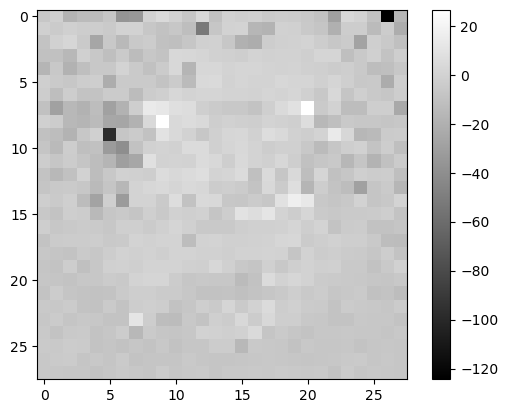

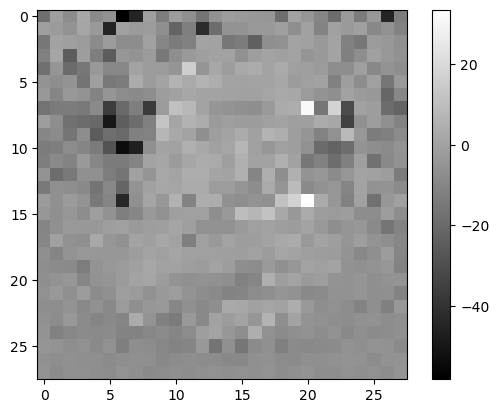

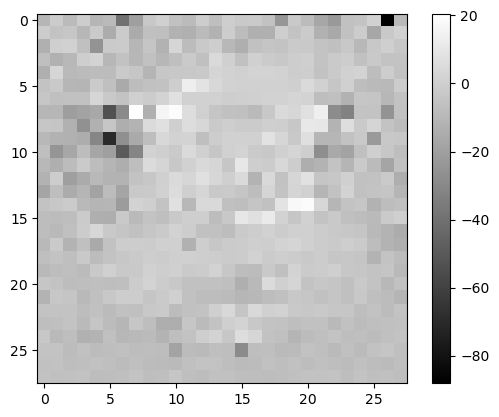

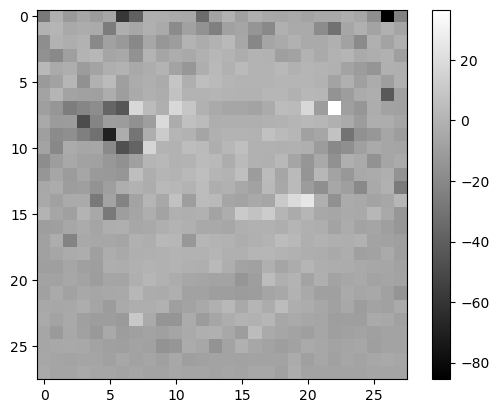

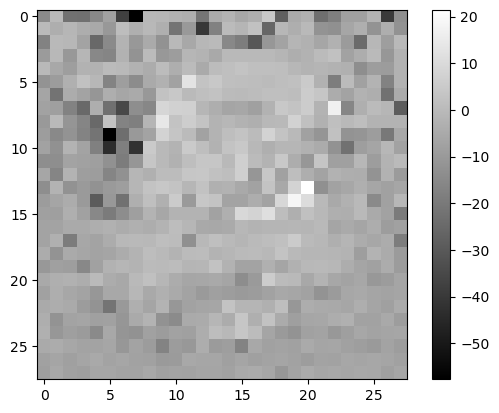

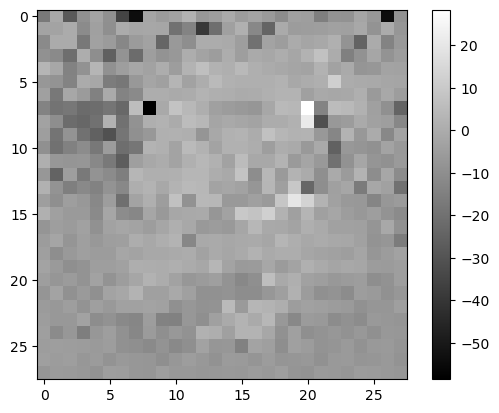

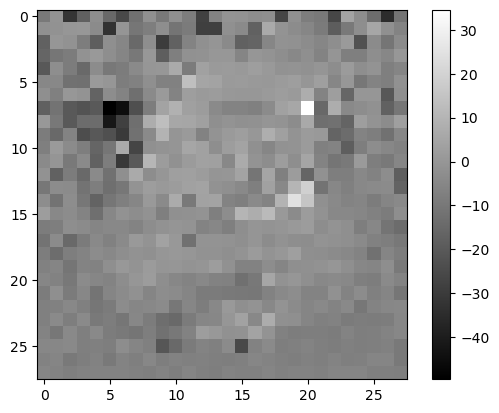

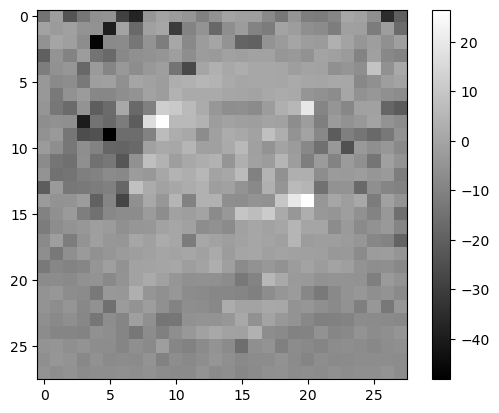

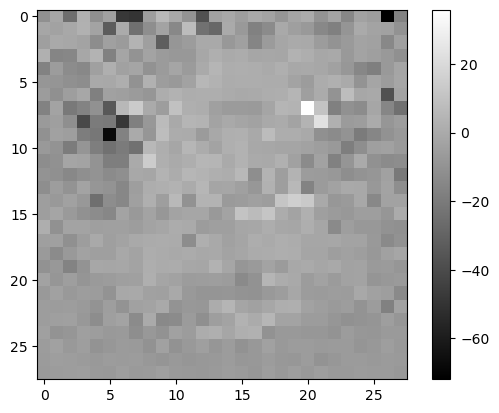

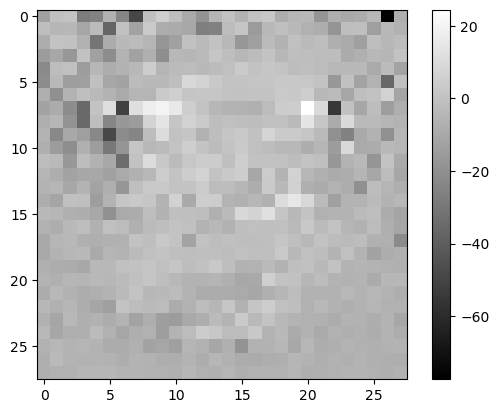

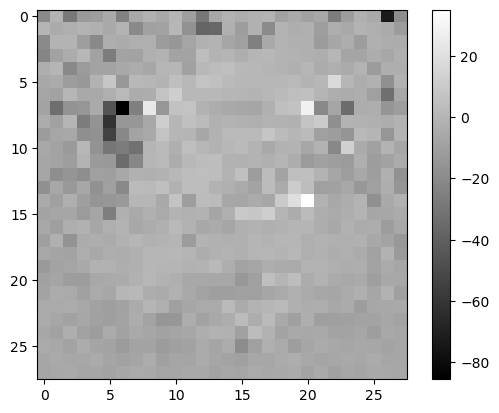

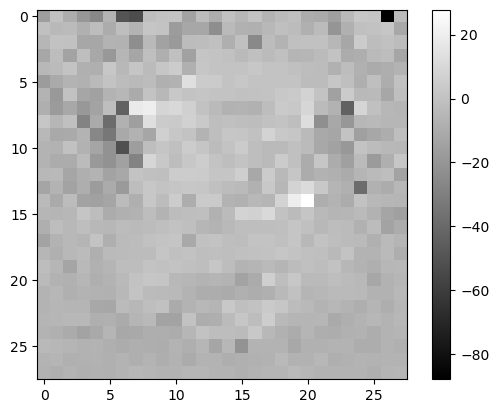

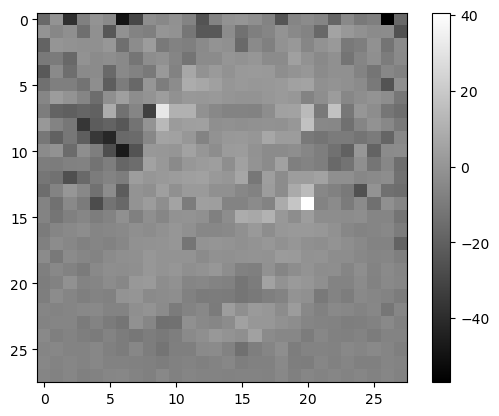

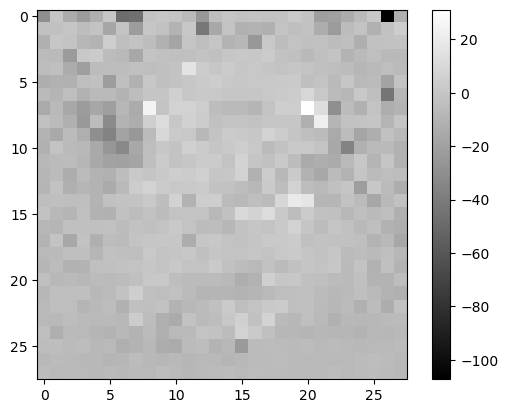

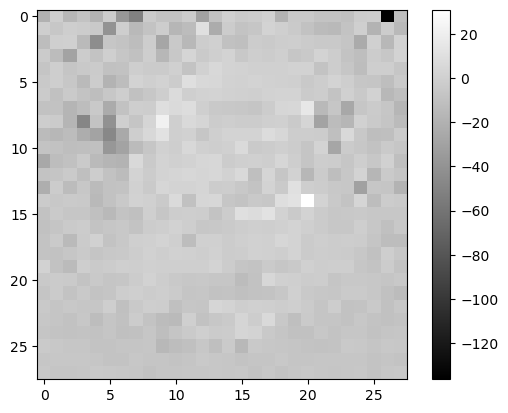

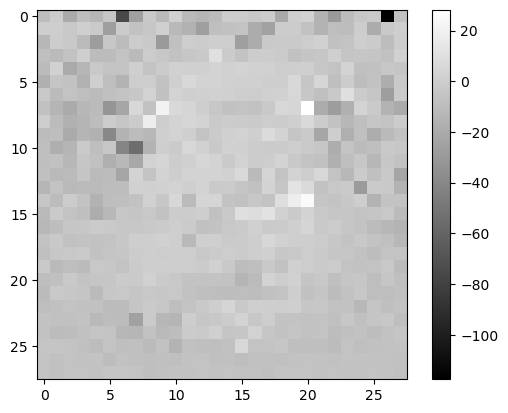

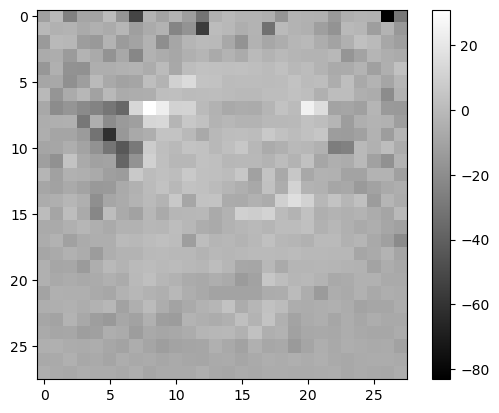

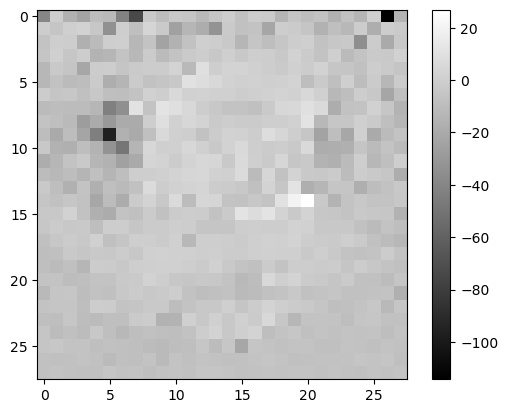

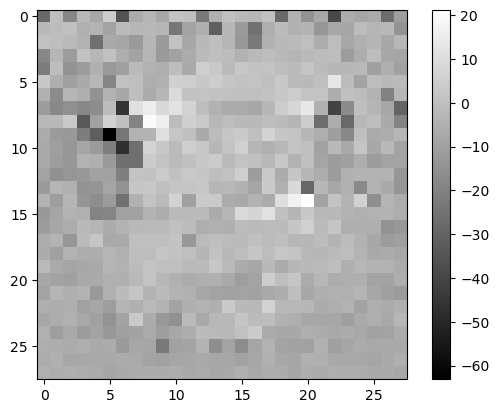

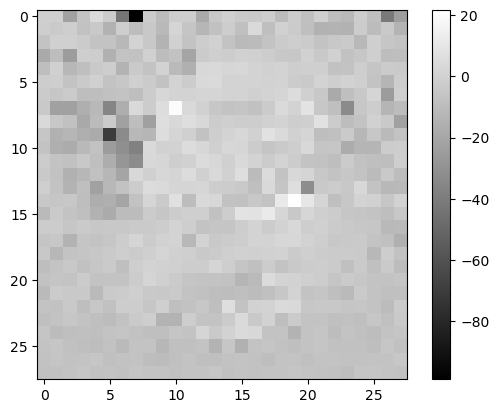

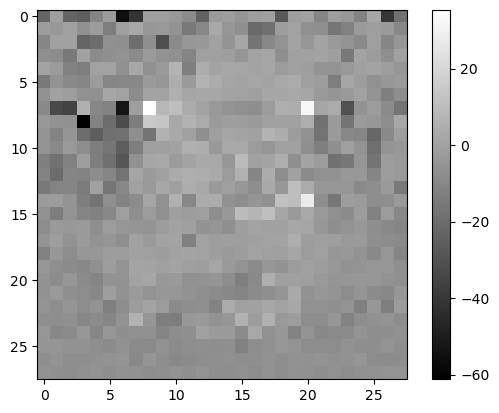

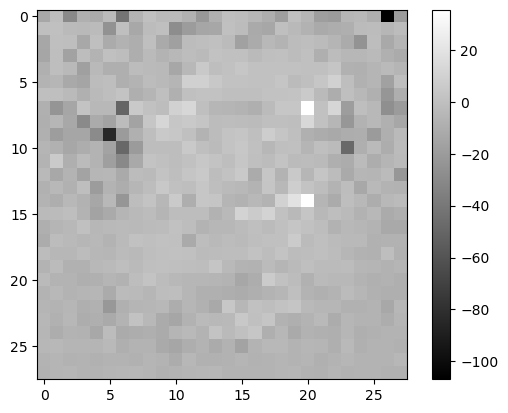

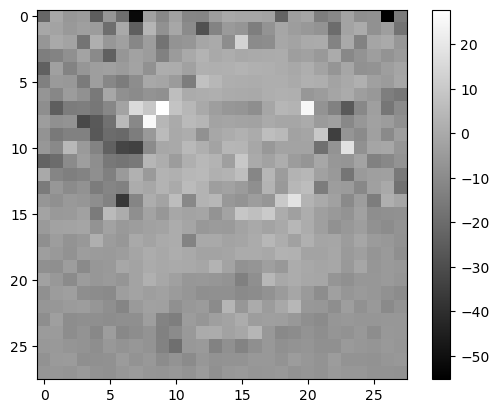

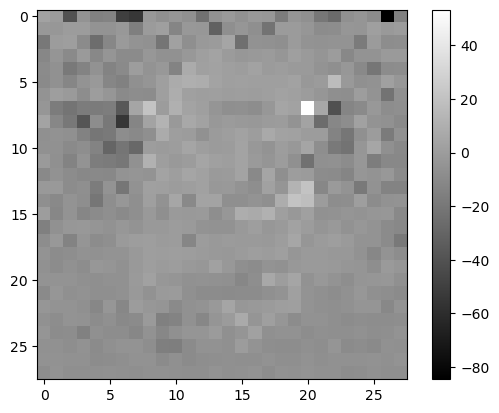

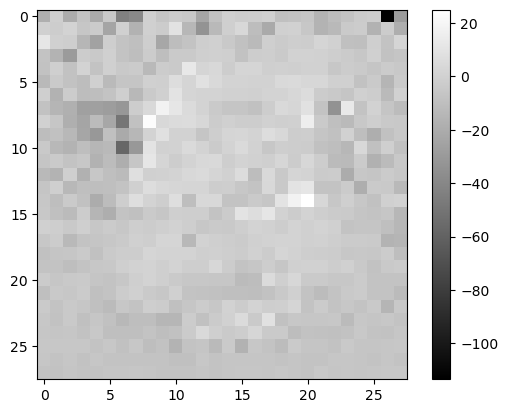

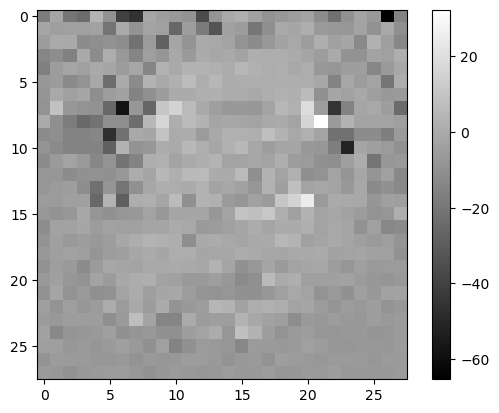

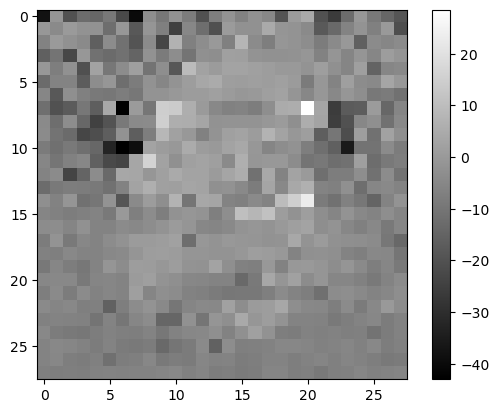

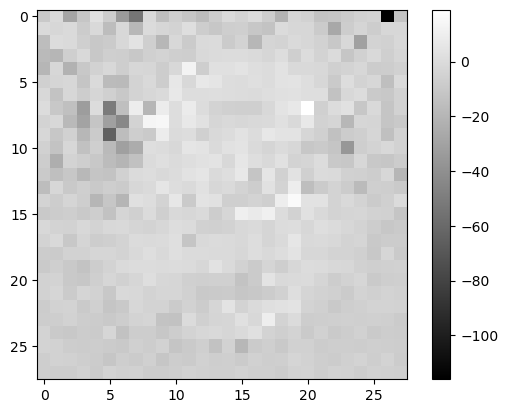

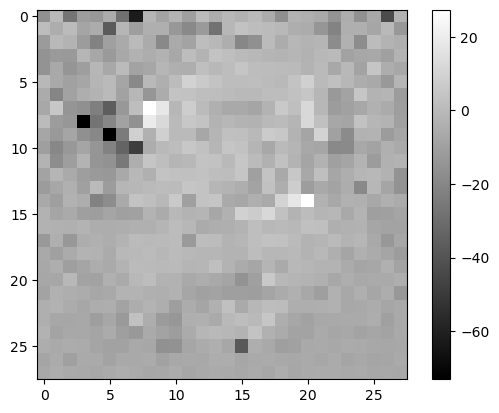

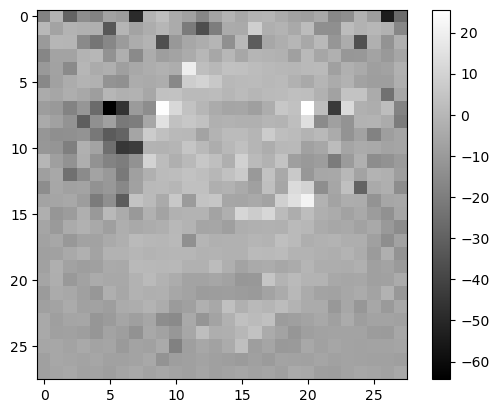

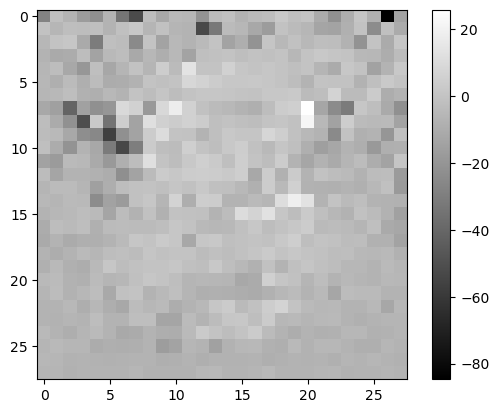

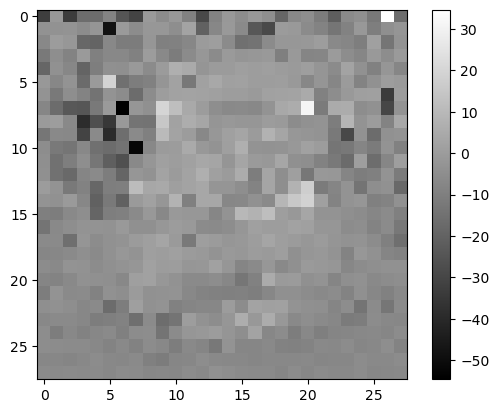

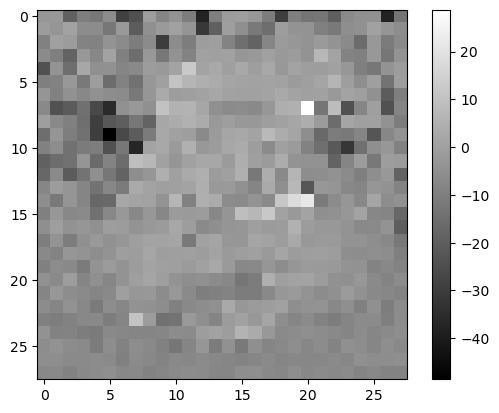

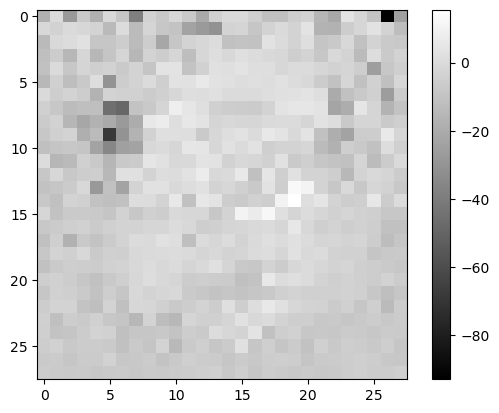

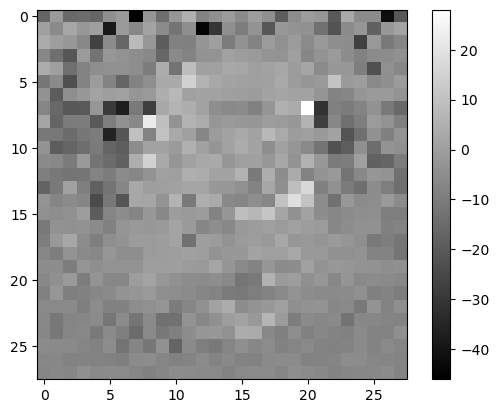

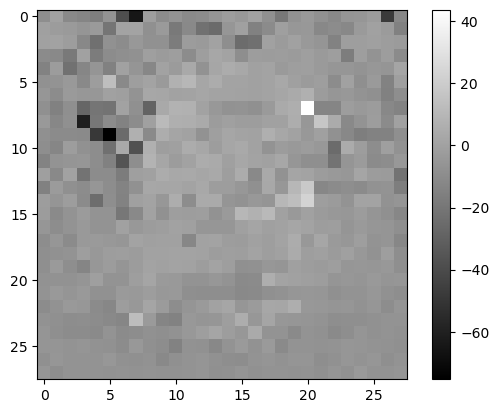

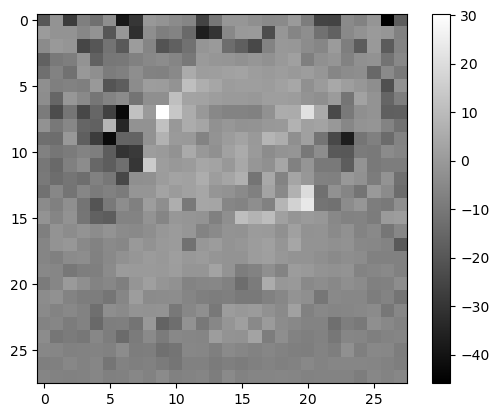

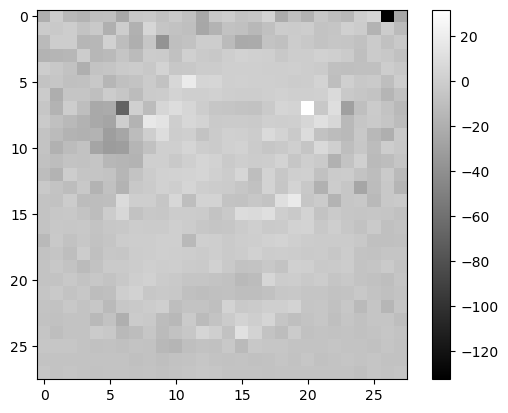

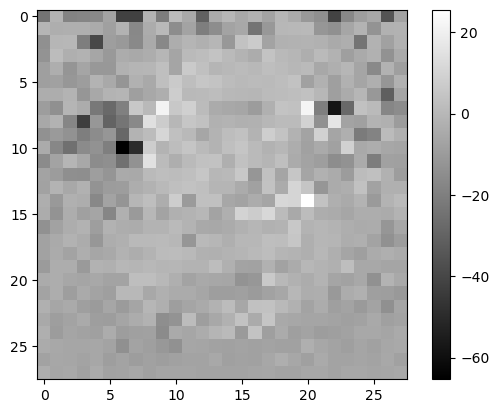

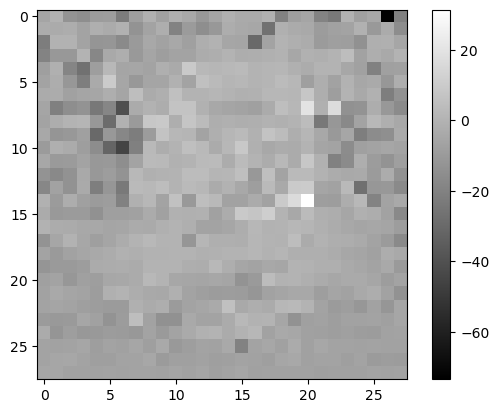

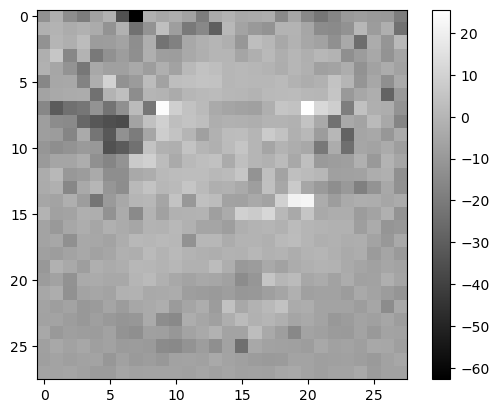

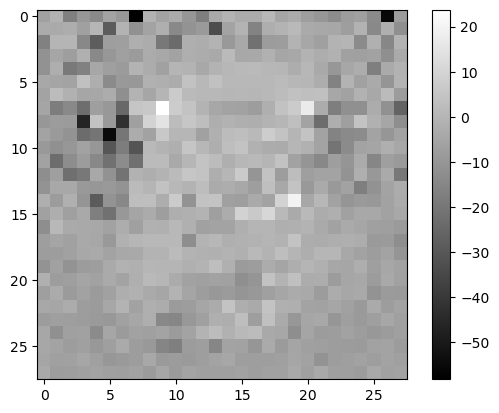

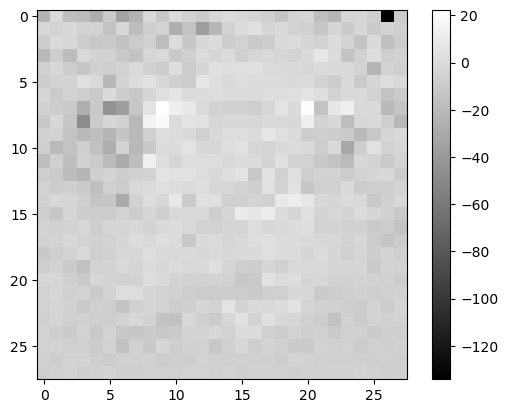

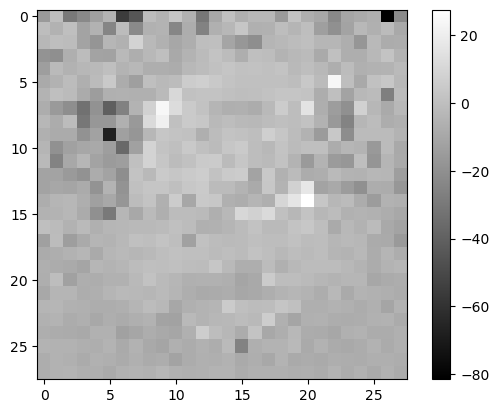

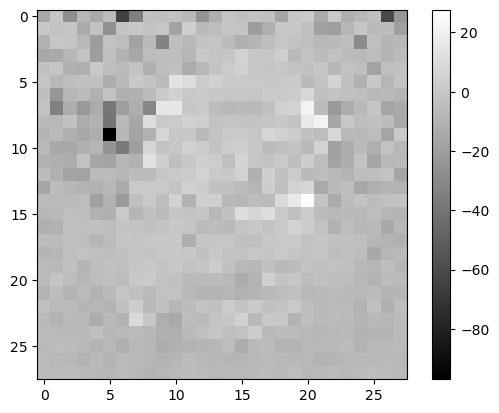

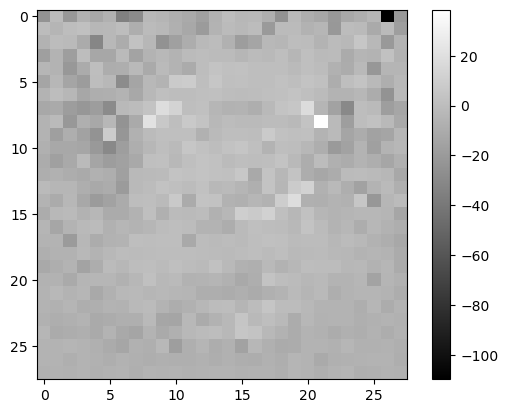

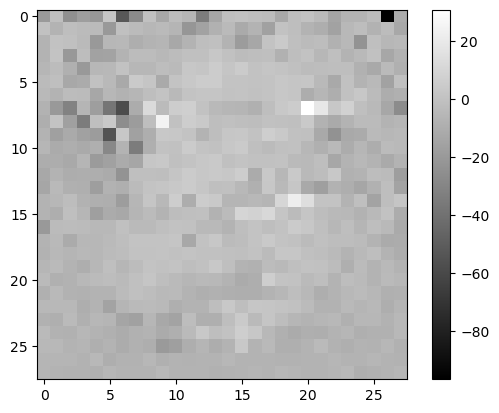

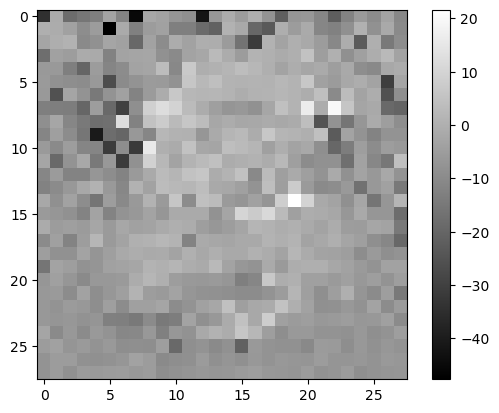

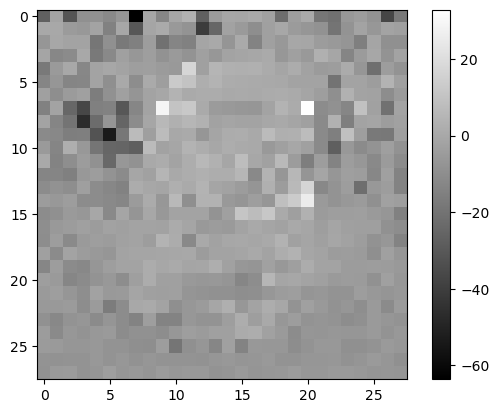

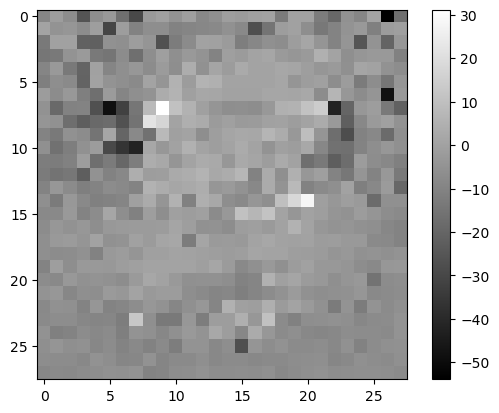

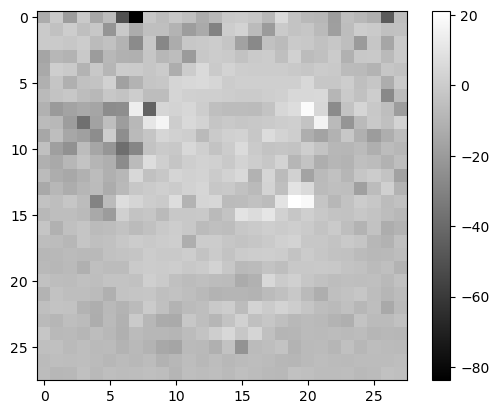

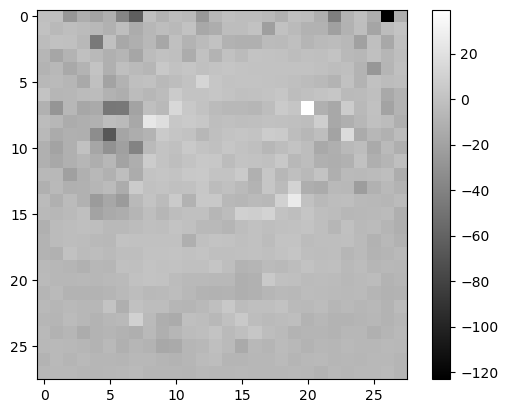

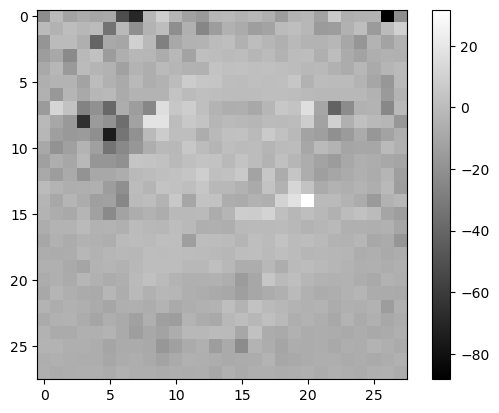

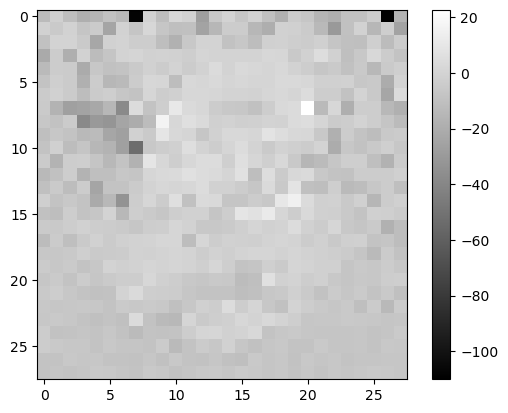

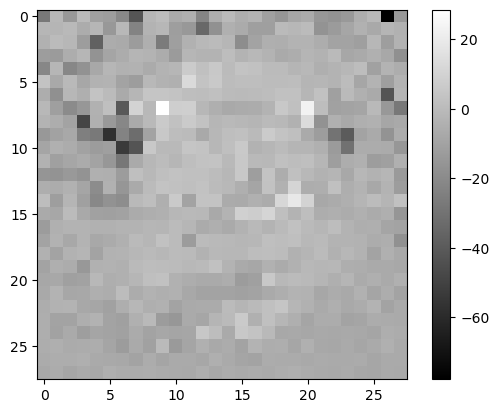

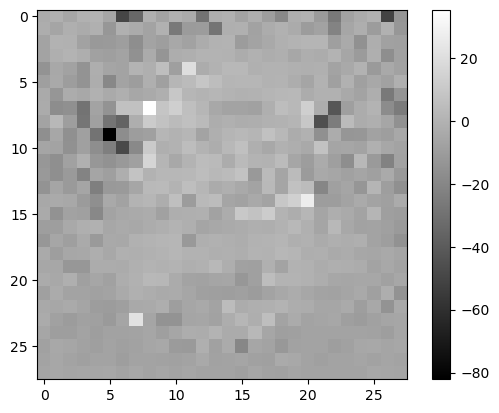

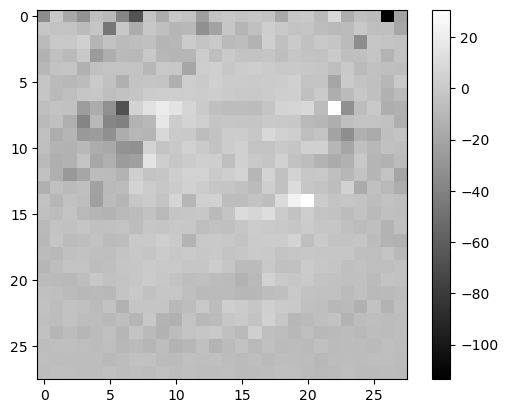

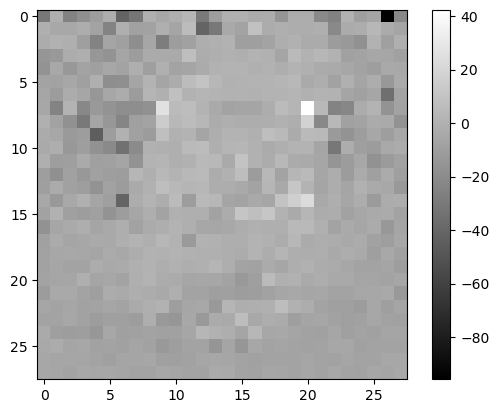

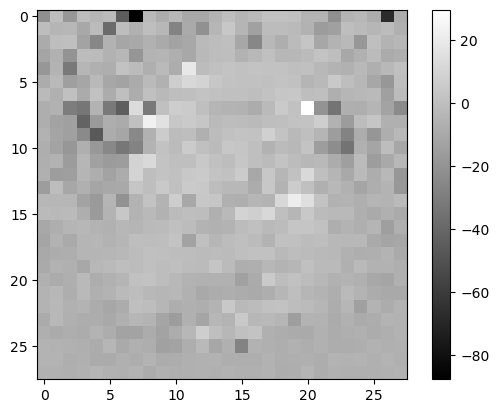

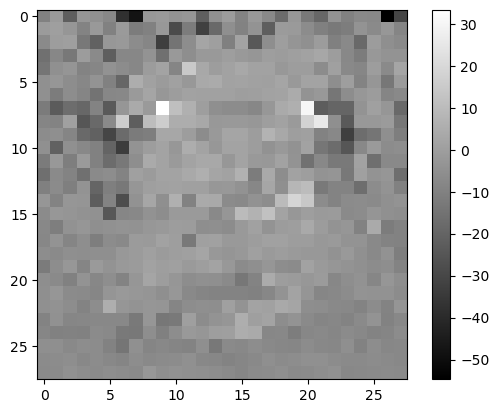

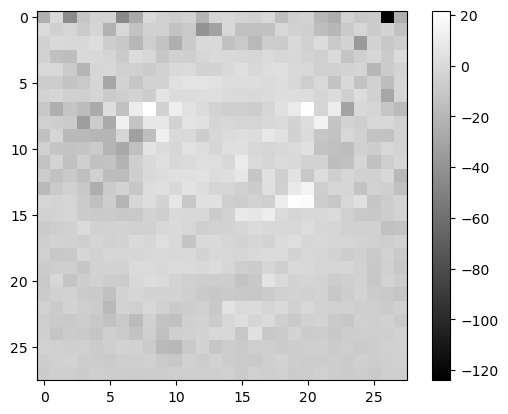

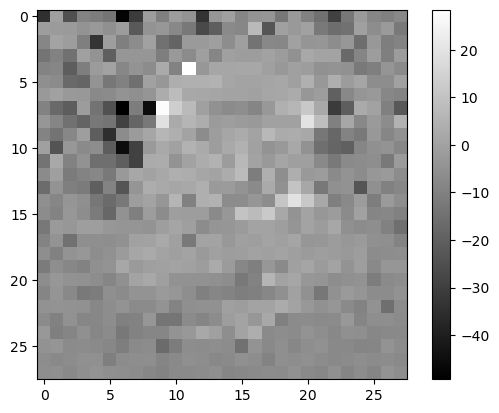

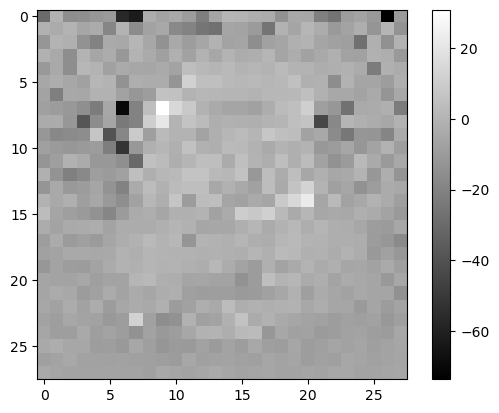

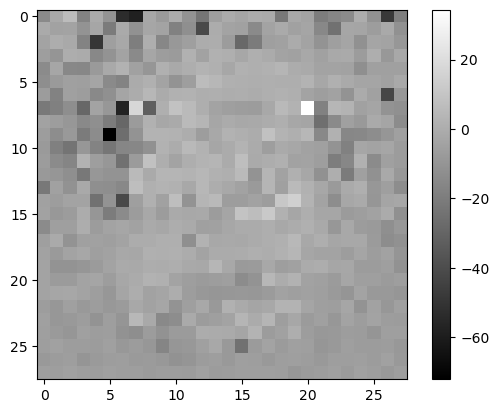

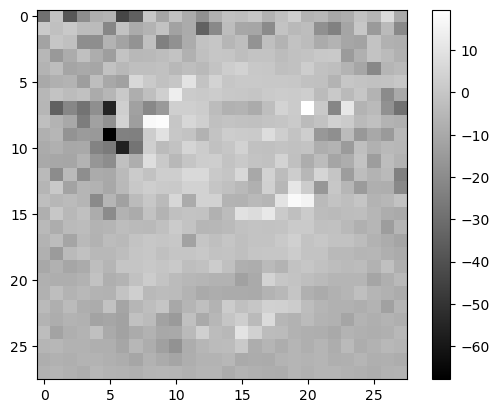

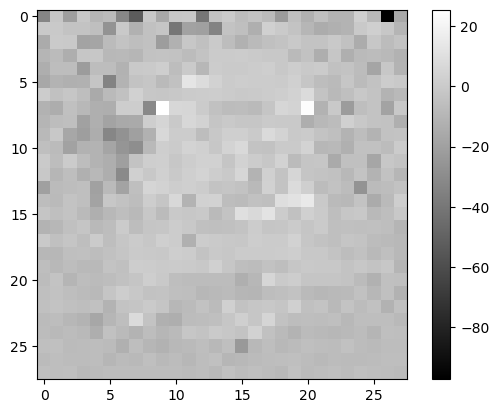

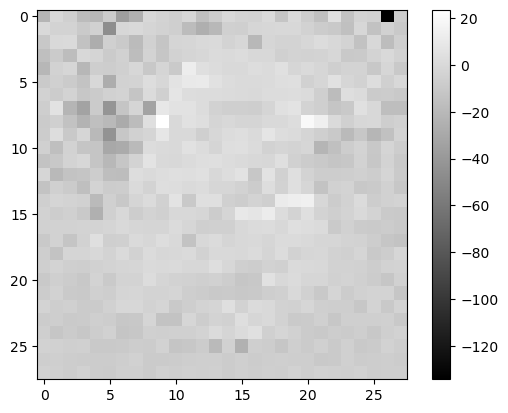

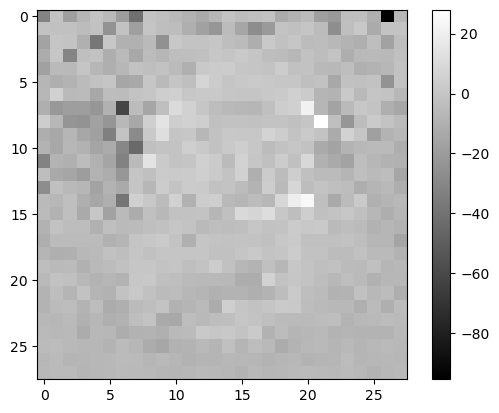

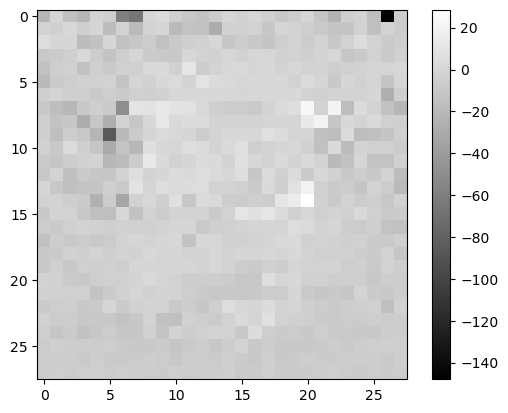

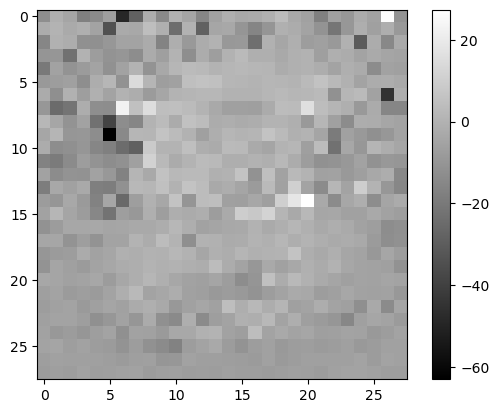

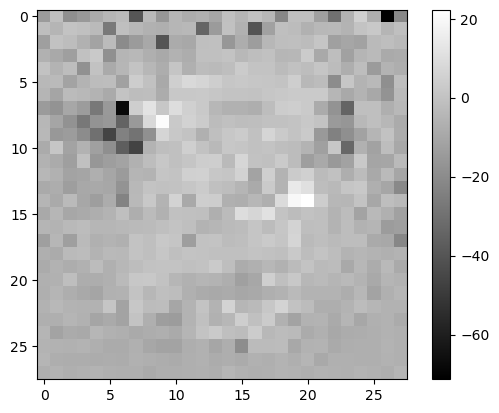

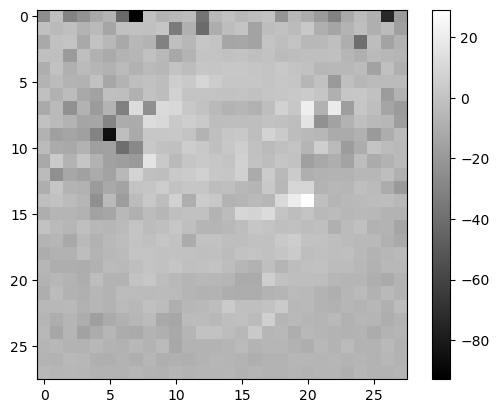

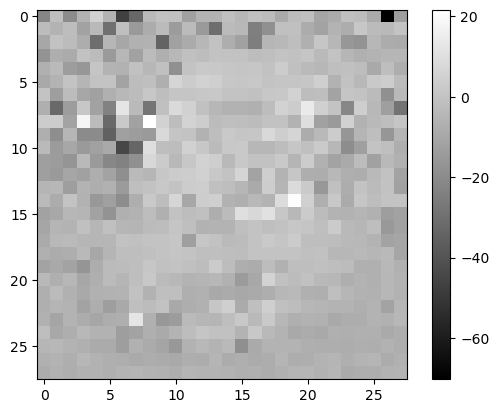

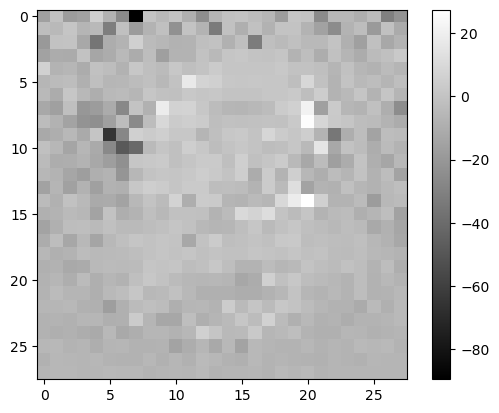

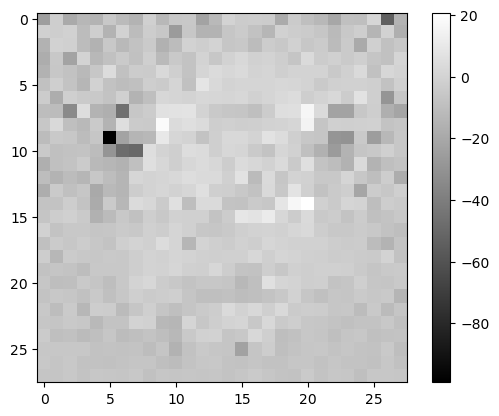

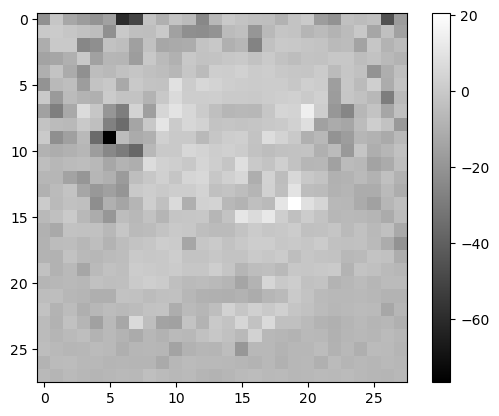

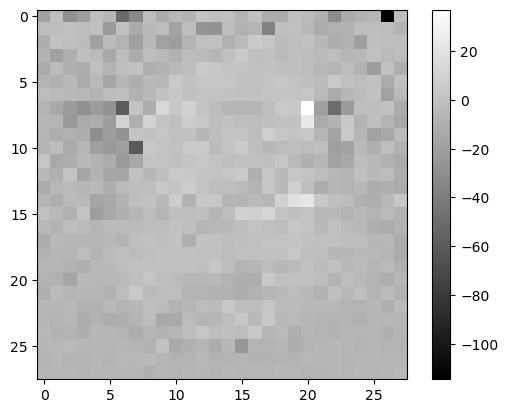

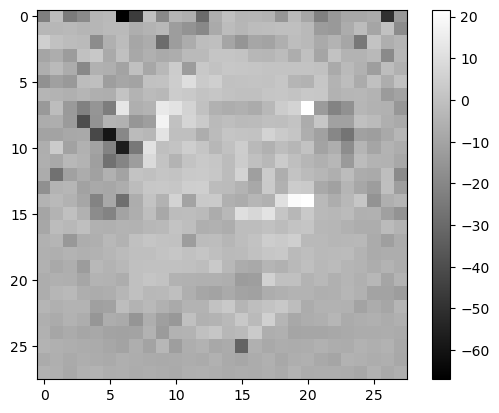

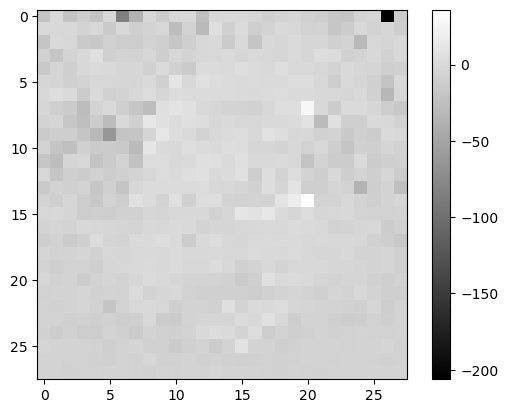

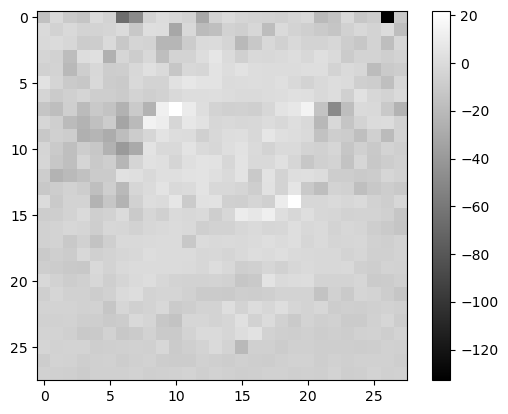

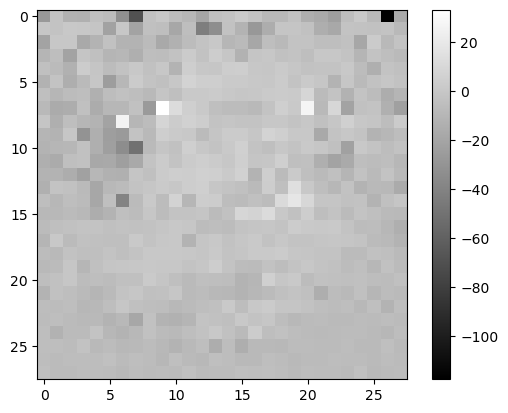

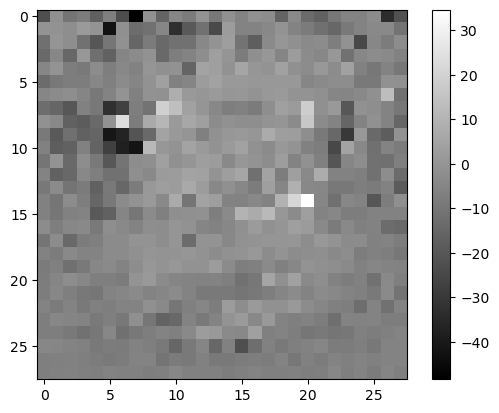

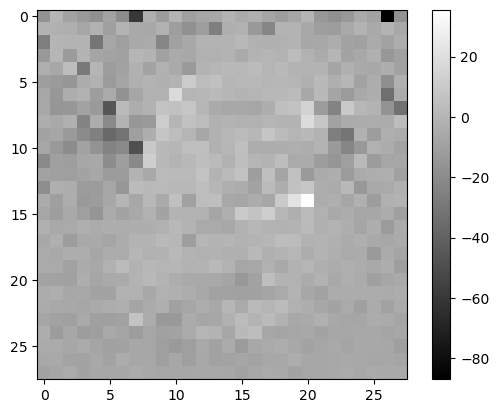

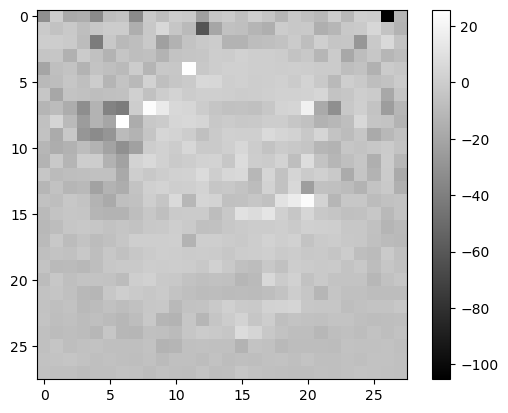

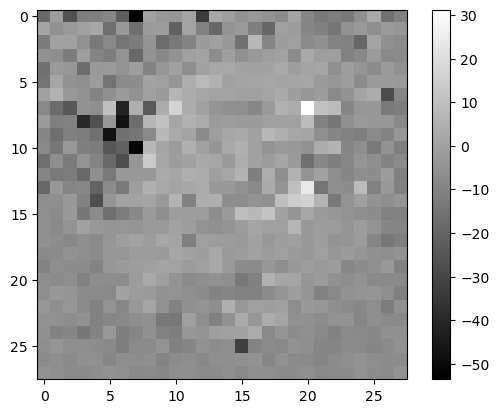

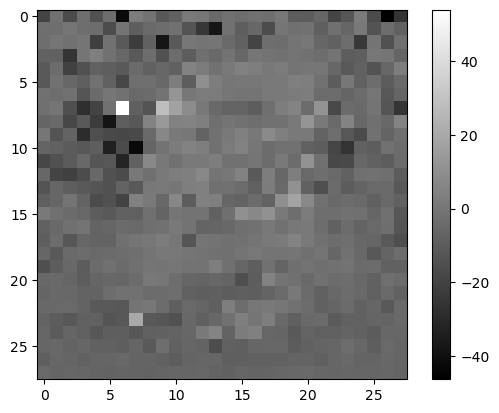

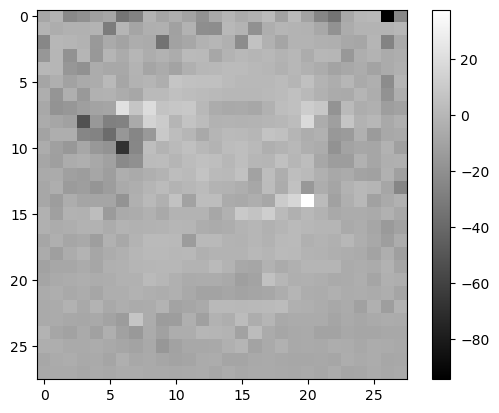

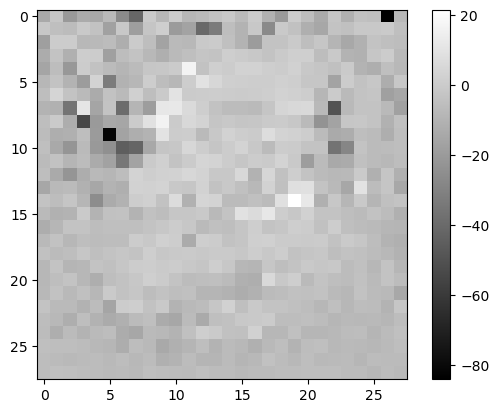

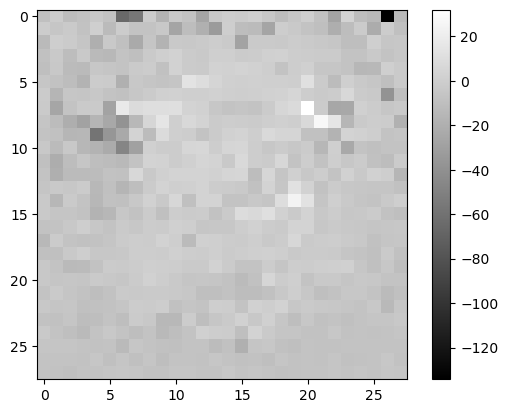

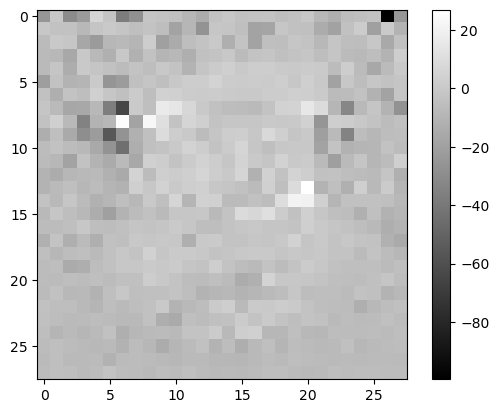

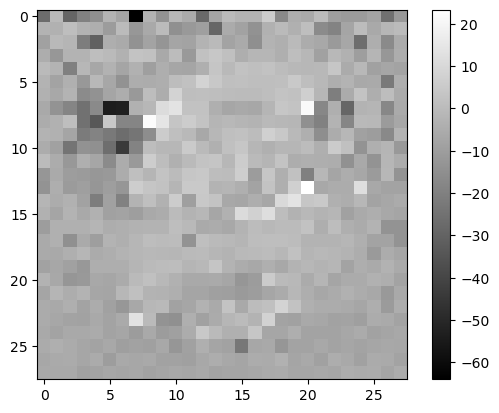

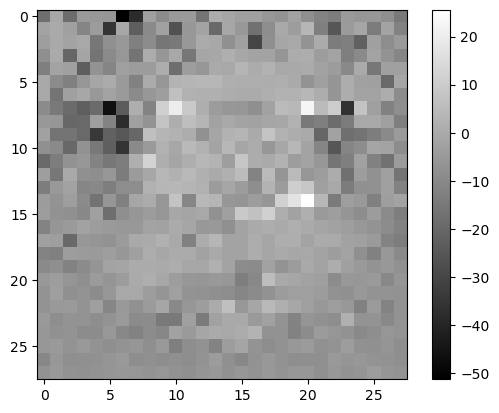

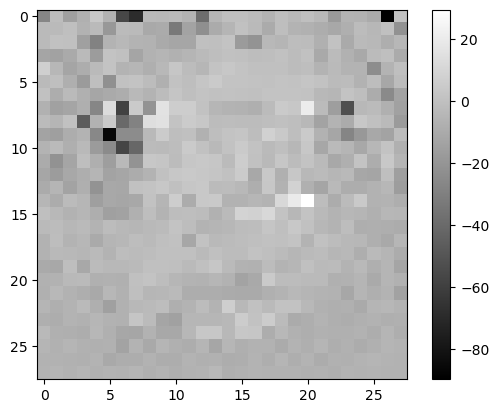

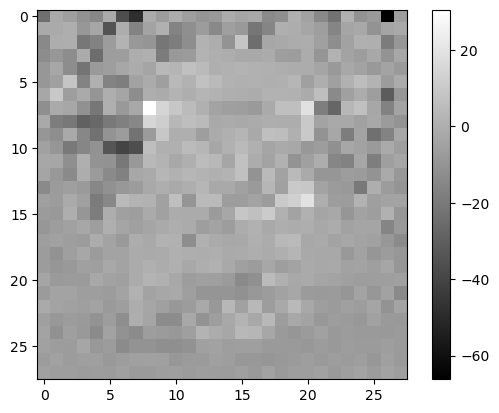

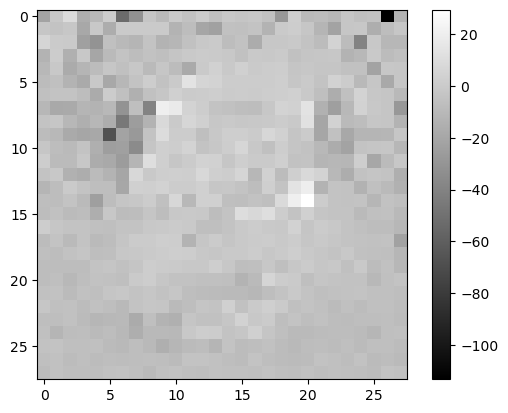

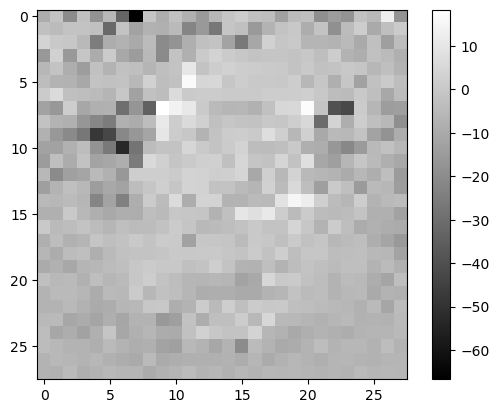

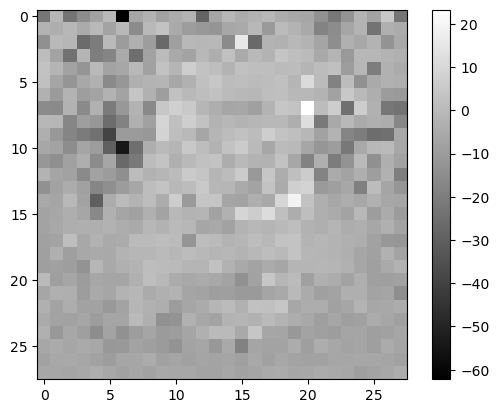

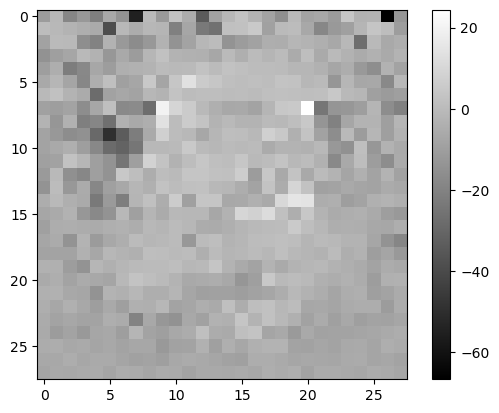

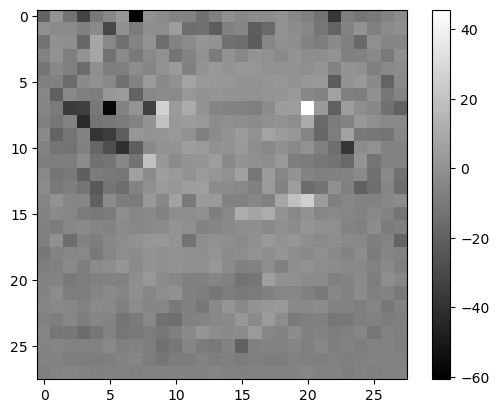

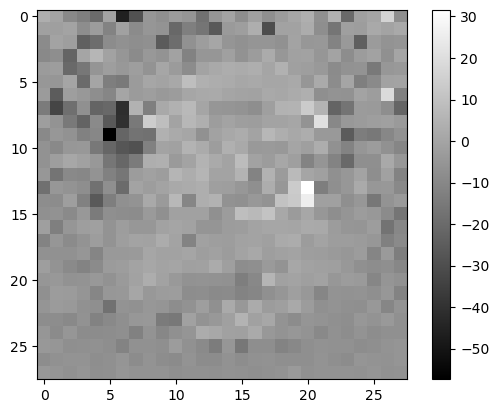

In [7]:
for i in range(num_gen_samples):
    plt.imshow(sample[i].reshape(28, 28), cmap='gray')
    plt.colorbar()
    plt.show()